In [1]:
########################Import Modules##########################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stat
import corner
import copy as Makecopy
import time
from matplotlib import colors
import scipy as sp

from ipywidgets import IntProgress
from IPython.display import display

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

#####################################

# Define Prior , Likelihood functions

# Prior

In [28]:
def prior(params,num_of_model_sources):
    a = params[3]  #,params[7]
    
    P_X = (1/npix)**(num_of_model_sources)
    P_Y = (1/npix)**(num_of_model_sources)
    P_A = sp.stats.expon.pdf(a)
   # P_A1 = sp.stats.expon.pdf(a1)
    P_r = 1
    
    return P_X*P_Y*P_A*P_r

In [29]:
def Cube_points(u):                                                                               
    points_source_list = []                                                                            
                                                                                                      
    for i in range(num_of_model_sources):                                                             
        X = sp.stats.uniform.rvs(0,50)                                                            
        Y = sp.stats.uniform.rvs(0,50)                                                           
        R = 4                                                                   
        A = sp.stats.uniform.rvs(.1,20)                                                          
                                                                                                      
        points_source_list.extend([X,Y,R,A])      #                              
                                                                                                      
    return points_source_list

# Model Function

In [30]:
def Model_function(params,noise):
    '''Return the model value given X,Y,R, and A paramters'''
       
    x = np.arange(0, npix, 1, float)
    y = x[:,np.newaxis]
    n = noise
    
    def tau(x,y,X,Y,R,A):  #Circularly  Gaussian Shaped function
        term1 = ((x-X)**2 + (y-Y)**2)/(2*R**2)
        
        return A*np.exp(-term1)
    
    source_template_model = np.zeros((npix,npix))
    params_new = np.reshape(params,(int(len(params)/4),4))  # change shape of array to index each source. from
                                                          # n-dimension to a k-4 dimennsion array.
    for i in range(len(params_new)):
        
        X,Y,R,A = params_new[i][0],params_new[i][1],params_new[i][2],params_new[i][3]
        source_template_model += tau(x,y,X,Y,R,A)
    
    return source_template_model + n

# Likelihood Function

In [31]:
def Log_Likelihood(data=None,sigma=None,model=None):
    
    '''Return the Log-Likelihood.
       
    Keyword arguments:
    sigma -- noise level
    model    -- Model
    data     -- The data'''
    #Unit test for shape of data amd model
    assert data.shape == model.shape
    
    N = len(data)
    
    Log_Like =  -0.5*np.sum(((1/sigma**2)*(data-model)**2))
    
    return Log_Like


In [32]:
def log_plus(x,y):
    '''Return the addition of x + y in log-space'''
    if x>y:
        return x+np.log(1+np.exp(y-x))
    
    else:
        return y+np.log(1+np.exp(x-y))

In [33]:
def tau(x,y,X,Y,R,A):  #Circularly  Gaussian Shaped function
    term1 = ((x-X)**2 + (y-Y)**2)/(2*R**2)
    
    return A*np.exp(-term1) 

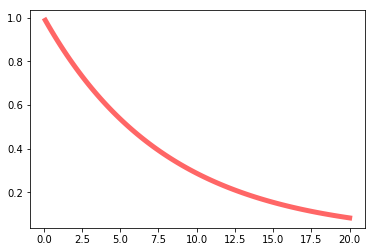

In [34]:
x = np.linspace(0.1,20, 100)

plt.plot(x, sp.stats.expon.pdf(x/8),'r-', lw=5, alpha=0.6, label='expon pdf')

# Generate Image

In [35]:
x = np.arange(0, 50, 1, float)
y = x[:,np.newaxis]

X1 = 32.8
Y1 = 24.8 
R1 = 4
A1 = 20


Noise = np.random.normal(0,1,(50,50))

In [36]:
Source_Image = tau(x,y,X1,Y1,R1,A1)  + Noise

Text(0,0.5,'Arbitrary Flux')

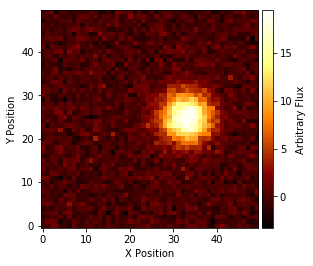

In [37]:
ax = plt.subplot(111)
im = ax.imshow(Source_Image,origin='lower',cmap='afmhot',)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.ylabel('Arbitrary Flux')

# Active Points

In [42]:
num_of_active_points = 100
num_of_model_sources = 1
ndim = 4*num_of_model_sources
npix = 50
#Save objects
points = np.zeros((num_of_active_points,ndim))

#log_likelihood of live objects
log_like_of_live_points = np.zeros((num_of_active_points))


#Generate Live objects
for i in range(num_of_active_points):
    points[i,:] = Cube_points(u=np.random.uniform(0,1.0,size=ndim))
    model = Model_function(params=points[i,:],noise=Noise)
    log_like_of_live_points[i] = Log_Likelihood(data=Source_Image,sigma=Noise,model=model)
 

# Nest Init

In [43]:
nest = 5
keep = np.zeros((nest,ndim))  #store bad points
logl_sample = []     #Store Log-likelihood of samples
X_sample = []        #Store prior mass
   


logWT = []  #Store  weight =width*likelihood


logZ = -1e300     # SUM(weights)= Z Evidence
H = 0


mcmc_steps = 2

# Main Nest

In [47]:
progressor = IntProgress(
    value=0,
    min=0,
    max=nest,
    step=1,
    description='Loading:',
    bar_style='success',
    orientation='horizontal'
) # instantiate the bar
display(progressor)
## MAIN NS LOOP##

#Outer interval 
logw = np.log(1.0 - np.exp(-1.0 / num_of_active_points))

start = time.time()
for i in range(nest):
    # Draw worst object with L* from n points
    worst = np.argmin(log_like_of_live_points)
    
    #Save worst opbject
    keep[i,:] = points[worst]
    logl_sample.append(log_like_of_live_points[worst])
    
    #Save prior mass
    X_sample.append(logw)
    
    #Weight
    logwt = logw + log_like_of_live_points[worst]
    
    
    #Save weight
    logWT.append(logwt)
    
    #Update Evidence Z
    logZnew = log_plus(logZ,logwt)   #np.logaddexp(logZ,logwt)     #CHANGED THIS LINE
    
    #Update H information
    H = np.exp(logwt-logZnew)*log_like_of_live_points[worst] \
    +np.exp(logZ-logZnew)*(H+logZ)-logZnew
    
    #Update logZ
    logZ = logZnew
    #Shrink interval
    logw -= 1.0/num_of_active_points
    

    while True:#----copy a random point and do mcmc from there-----
        copy = np.random.randint(len(points))
        if (copy != worst):break
            
    points[worst] = Makecopy.deepcopy(points[copy])
    log_Likelihood_old =  log_like_of_live_points[copy]
    
    theta = points[copy]
    
    #UNIT TEST check for correct shape
    assert theta.shape == (ndim,)
    
   # initialize mcmc params
    
    scale = 1.0
    accept = 0
    reject = 0
    for mcmci in range(mcmc_steps):  #Evolve within current worst likelihood L>L* , draw new point under constraint
    #while True:   
        propose_step = np.random.normal(0,scale=scale,size=ndim)
        new_point = theta + propose_step
        
        #Make all Amp == R_constant
        new_point_reshape = np.reshape(new_point,(int(len(new_point)/4),4))
        new_point_reshape[:,-2] = 4
        
        new_point = new_point_reshape.flatten()
        ##############################################################################
        #np.seterr(divide='ignore')

        #Calculate Log_likelihood of new point
        model = Model_function(params=new_point,noise=Noise)
        
        #Prior_current and Prior_old
        
        Prior_current = prior(new_point,num_of_model_sources)
        Prior_old     = prior(theta,num_of_model_sources)
        
        
        #Posterior_current and Posterior_old
        Log_Like_new = Log_Likelihood(data=Source_Image,sigma=Noise,model=model)
        
      
        Posterior_current = Log_Like_new + np.log(Prior_current)
        
        Posterior_old = log_Likelihood_old + np.log(Prior_old)
       
    ##################################################################################################
        #Acceptance ratio alpha
        alpha = Posterior_current/Posterior_old
        
        print(alpha)
    
        if alpha>=1:
            points[worst,:] = new_point  #Replace worst point with new point
            log_like_of_live_points[worst] = Log_Like_new   #Replace the worst likelihood with new one  
            accept += 1
            
            
        else:
            u = np.random.uniform()
            if u <= alpha :
                points[worst,:] = new_point 
                log_like_of_live_points[worst] = Log_Like_new
                accept += 1
                 
                
            else:
                theta = theta
                reject +=1
                
        #Changing the scale
        if accept > reject:
            scale *= np.exp(1./accept)
        if accept < reject:
            scale /= np.exp(1./reject)

    
    #Acceptance_Ratio = accept/(accept+reject)
    #Acceptance[i] =  Acceptance_Ratio
    
    progressor.value += 1
    
                
    if i > nest*np.exp(H)/np.log(2.):
        #print("ok")
        
        break

end = time.time()
if progressor.value == progressor.max:
    progressor.description = "Done!"
    
Z = logZ
Z_err = np.sqrt((H)/num_of_active_points)
H =  H       #np.exp(H)/np.log(2.)
#print("Acceptance Ratio :",Acceptance_Ratio)
print('Evidence Z = {0} +-{1} : Information H = {2} '.format(Z,Z_err,H))
print('time:',end-start)

IntProgress(value=0, bar_style='success', description='Loading:', max=5)

1.014485511069396
0.97710786756509
0.9984522533405652
1.049062819733739
1.0075933692293952
0.9844230482649449
1.0079658193247407
0.9691966141814862
1.0122661853020611
1.0721163207907052
Evidence Z = -8847456.859443296 +-0.21564243598599336 : Information H = 4.650166019797325 
time: 0.011096477508544922


Text(0,0.5,'LogL')

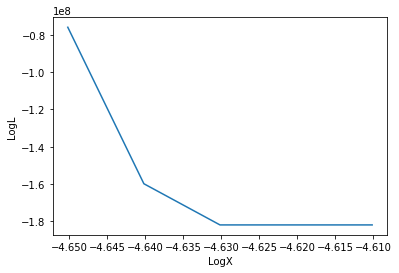

In [45]:
plt.plot(X_sample,logl_sample)
plt.xlabel('LogX')
plt.ylabel('LogL')

In [178]:
#Normalized samples
wt = np.exp((logWT)-max(logWT))
Weights = wt/sum(wt)

#Effective sample size
effective_sample_size = int(np.exp(-np.sum(Weights*np.log(Weights+1e-300))))
S = 0
sample = np.zeros((effective_sample_size,ndim))


print('Effective Sample Size : {}'.format(effective_sample_size))

#Progress bar
progressor_samples = IntProgress(
    value=0,
    min=0,
    max=effective_sample_size,
    step=1,
    description='Loading:',
    bar_style='success',
    orientation='horizontal'
) # instantiate the bar
display(progressor_samples)

# Selecting the Effective sample
while True:
    rnd_point = np.random.randint(len(keep))
    #proba = prob_weighted[rnd_point]/max(prob_weighted)
    proba = Weights[rnd_point]/max(Weights)

    if np.random.rand() < proba:
        sample[S,:] = keep[rnd_point,:]
        
        S += 1
        progressor_samples.value += 1
    if S >= effective_sample_size:
        break


Effective Sample Size : 1517


IntProgress(value=0, bar_style='success', description='Loading:', max=1517)

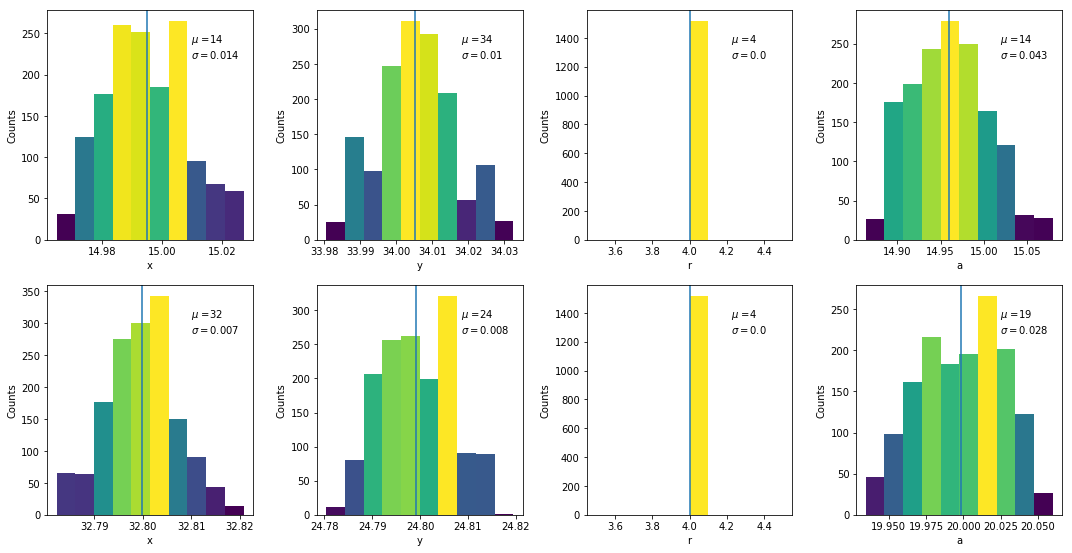

In [179]:
fig = plt.figure(figsize=(15,15))

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)

Labels = ['x','y','r','a']*num_of_model_sources
for L,num in zip(Labels, range(0,16)):
    
    ax = fig.add_subplot(4,4,num+1)
    N, bins, patches = ax.hist(sample[:,num])
    
    fracs = N.astype(float) / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
    norm = colors.Normalize(fracs.min(), fracs.max())

    mean = np.mean(sample[:,num])
    sigma = np.std(sample[:,num])
    
    
    
    ax.annotate("$\mu$"+" ="+str(int(mean)) +'\n'+'$\sigma =$'+str(round(sigma,3)), xy=(0.7, 0.8), xycoords="axes fraction")

    
# Now, we'll loop through our objects and set the color of each accordingly
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    ax.set_xlabel(L)
    ax.set_ylabel('Counts')
    ax.axvline(mean)
    
plt.tight_layout()

In [103]:
np.random.randint(-1,2)

1

In [120]:
[-1,1][np.random.randint(0,2)]

-1